In [1]:
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
df_chfusd = pd.read_csv('/content/CHF-USD Exchange Rate Clean.csv')
df_trends = pd.read_excel('/content/World_GT_Full.xlsx')

In [3]:
df_trends['Date'] = pd.to_datetime(df_trends.iloc[:, 0], infer_datetime_format=True)
df_chfusd['Date'] = pd.to_datetime(df_chfusd.iloc[:, 0], infer_datetime_format=True)

In [4]:
df_chfusd['CHF/USD Log Difference'] = np.log(df_chfusd['Adj Close']) - (np.log(df_chfusd['Adj Close']).shift(1))
df_chfusd['CHF/USD Log Difference']
df_chfusd = df_chfusd.dropna()

In [5]:
ts_df = df_chfusd.merge(df_trends, how = 'inner', on = ['Date'])

In [6]:
ts_df = ts_df.drop(['Log_Difference','Adj Close'], axis = 1)
ts_df = ts_df.set_index(ts_df.iloc[:,0])
ts_df = ts_df.drop(['Date'], axis = 1)
ts_df

,CHF/USD Log Difference,swiss franc,Europe,EUR,Switzerland,CHF,NASDAQ,S&P500,VIX,volatility,Germany,UK,sterling pound,GBP,Greece,Italy,Spain,France,DAX,unemployment,recession,euro,crisis,fed,finance,financial crisis,federal reserve,gold,inflation,treasuries,OPEC,contagion,corruption,disaster,futures,forwards,president,parliament,aid,EU,...,steel,silver,bronze,corn,commodities,natural gas,agriculture,emerging market,trade,interest rate,GDP,exports,imports,jobs,tax,tariff,uncertainty,gini,inequality,insurance,pension,liquidity,diversification,alpha,currency,CAPM,fixed income,commission,SEC,yield,real estate,eurodollar,regulations,deficit,yield curve,LIBOR,2008,bubble,energy,1939
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-01,-0.002987,0,42,3,6,3,12,27,2,0,9,78,0,0,19,6,25,38,1,4,0,6,18,9,27,0,12,17,13,0,0,0,64,6,9,32,3,4,13,3,...,20,49,54,23,8,8,21,0,43,4,26,8,79,9,16,0,0,11,0,44,59,0,16,45,42,0,0,8,30,6,58,0,37,7,0,15,0,46,37,18
2004-01-02,0.000242,0,58,12,8,2,22,0,19,31,10,76,0,1,15,5,23,32,3,6,0,5,12,16,47,0,12,18,32,0,8,0,6,5,12,8,3,1,23,3,...,18,36,20,10,26,27,27,0,38,18,21,33,90,11,21,34,15,0,0,68,46,0,8,51,48,0,0,13,27,41,68,0,33,15,0,23,0,30,43,28
2004-01-05,0.006472,0,39,0,4,0,14,0,30,0,7,23,0,0,14,6,17,15,0,7,0,3,26,10,41,0,0,27,20,0,0,0,0,15,3,0,5,0,10,2,...,15,42,39,5,14,30,56,0,40,37,100,14,28,16,21,23,0,14,59,50,19,0,0,55,66,0,0,21,68,30,82,0,34,51,0,0,0,23,52,15
2004-01-06,0.000081,0,73,5,6,2,35,0,10,30,12,100,0,0,23,6,24,40,2,10,0,6,20,18,87,0,27,19,64,0,3,0,41,8,19,0,5,8,20,5,...,29,37,43,21,25,19,42,12,60,19,31,36,41,14,23,59,10,5,17,100,67,15,11,57,74,22,39,26,70,31,54,15,80,47,74,75,0,29,84,45
2004-01-07,-0.006150,0,60,2,7,4,32,0,0,32,10,79,0,0,22,7,31,31,1,8,1,6,26,32,71,0,28,20,41,0,6,0,9,11,9,8,5,4,18,4,...,27,39,33,12,18,48,60,9,62,17,49,34,50,14,25,34,27,4,19,76,34,29,0,48,75,10,58,24,46,23,60,11,58,37,40,25,0,31,87,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-08,-0.004983,2,26,14,10,14,45,23,18,9,6,38,3,6,15,4,10,15,19,16,4,7,15,18,67,2,6,29,26,2,1,1,23,18,18,2,3,6,16,8,...,28,37,34,23,53,33,21,1,33,19,15,22,7,9,19,21,11,9,15,41,59,15,1,39,24,3,5,7,44,42,16,0,15,38,1,3,1,36,70,9
2021-09-09,-0.002596,1,23,14,8,13,45,31,16,9,6,38,2,6,13,4,9,12,22,13,4,7,16,20,63,4,6,27,22,2,2,1,25,18,18,3,3,5,17,8,...,25,36,37,22,40,29,23,2,34,18,15,25,9,9,18,21,7,8,16,39,52,12,1,38,24,8,4,7,44,41,15,1,15,55,2,2,1,37,66,8
2021-09-10,0.005799,1,20,13,7,12,41,27,10,7,5,37,1,5,11,4,9,11,18,11,3,7,14,19,57,2,6,27,22,2,2,1,19,17,15,2,3,5,15,8,...,23,36,37,23,47,25,20,3,36,16,15,23,7,8,16,18,8,7,14,36,48,11,1,36,22,5,4,6,41,37,14,0,11,45,0,2,1,39,60,7


In [7]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(ts_df.copy())

In [8]:
window_size = 2
data['CHF/USD_RealVol'] = data['CHF/USD Log Difference'].rolling(window_size).std()*(252**0.5)

In [9]:
data['CHF/USD_RealVol'].quantile(0.75) #75th Percentile

0.10116416573686328

In [10]:
# Adding the lag of the target variable from 6 steps back up to 24

for column in data:

  for i in range(1, 14):
      data[f"{column}_lag_{i}"] = data[column].shift(i)

In [11]:
data['HighVolMoment_CHF/USD'] = [1 if i > 0.10 else 0 for i in data['CHF/USD_RealVol']]

In [12]:
data

,CHF/USD Log Difference,swiss franc,Europe,EUR,Switzerland,CHF,NASDAQ,S&P500,VIX,volatility,Germany,UK,sterling pound,GBP,Greece,Italy,Spain,France,DAX,unemployment,recession,euro,crisis,fed,finance,financial crisis,federal reserve,gold,inflation,treasuries,OPEC,contagion,corruption,disaster,futures,forwards,president,parliament,aid,EU,...,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12,energy_lag_13,1939_lag_1,1939_lag_2,1939_lag_3,1939_lag_4,1939_lag_5,1939_lag_6,1939_lag_7,1939_lag_8,1939_lag_9,1939_lag_10,1939_lag_11,1939_lag_12,1939_lag_13,CHF/USD_RealVol_lag_1,CHF/USD_RealVol_lag_2,CHF/USD_RealVol_lag_3,CHF/USD_RealVol_lag_4,CHF/USD_RealVol_lag_5,CHF/USD_RealVol_lag_6,CHF/USD_RealVol_lag_7,CHF/USD_RealVol_lag_8,CHF/USD_RealVol_lag_9,CHF/USD_RealVol_lag_10,CHF/USD_RealVol_lag_11,CHF/USD_RealVol_lag_12,CHF/USD_RealVol_lag_13,HighVolMoment_CHF/USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-01,-0.002987,0,42,3,6,3,12,27,2,0,9,78,0,0,19,6,25,38,1,4,0,6,18,9,27,0,12,17,13,0,0,0,64,6,9,32,3,4,13,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2004-01-02,0.000242,0,58,12,8,2,22,0,19,31,10,76,0,1,15,5,23,32,3,6,0,5,12,16,47,0,12,18,32,0,8,0,6,5,12,8,3,1,23,3,...,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2004-01-05,0.006472,0,39,0,4,0,14,0,30,0,7,23,0,0,14,6,17,15,0,7,0,3,26,10,41,0,0,27,20,0,0,0,0,15,3,0,5,0,10,2,...,43.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2004-01-06,0.000081,0,73,5,6,2,35,0,10,30,12,100,0,0,23,6,24,40,2,10,0,6,20,18,87,0,27,19,64,0,3,0,41,8,19,0,5,8,20,5,...,52.0,43.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,28.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069930,0.036245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2004-01-07,-0.006150,0,60,2,7,4,32,0,0,32,10,79,0,0,22,7,31,31,1,8,1,6,26,32,71,0,28,20,41,0,6,0,9,11,9,8,5,4,18,4,...,84.0,52.0,43.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,15.0,28.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071731,0.069930,0.036245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-08,-0.004983,2,26,14,10,14,45,23,18,9,6,38,3,6,15,4,10,15,19,16,4,7,15,18,67,2,6,29,26,2,1,1,23,18,18,2,3,6,16,8,...,66.0,52.0,62.0,63.0,64.0,62.0,58.0,57.0,58.0,62.0,64.0,59.0,56.0,8.0,8.0,7.0,8.0,13.0,7.0,5.0,7.0,6.0,7.0,8.0,7.0,6.0,0.020731,0.004629,0.015264,0.025689,0.096450,0.156145,0.135427,0.046071,0.003212,0.068997,0.037140,0.038636,0.017805,0
2021-09-09,-0.002596,1,23,14,8,13,45,31,16,9,6,38,2,6,13,4,9,12,22,13,4,7,16,20,63,4,6,27,22,2,2,1,25,18,18,3,3,5,17,8,...,70.0,66.0,52.0,62.0,63.0,64.0,62.0,58.0,57.0,58.0,62.0,64.0,59.0,9.0,8.0,8.0,7.0,8.0,13.0,7.0,5.0,7.0,6.0,7.0,8.0,7.0,0.043176,0.020731,0.004629,0.015264,0.025689,0.096450,0.156145,0.135427,0.046071,0.003212,0.068997,0.037140,0.038636,0
2021-09-10,0.005799,1,20,13,7,12,41,27,10,7,5,37,1,5,11,4,9,11,18,11,3,7,14,19,57,2,6,27,22,2,2,1,19,17,15,2,3,5,15,8,...,66.0,70.0,66.0,52.0,62.0,63.0,64.0,62.0,58.0,57.0,58.0,62.0,64.0,8.0,9.0,8.0,8.0,7.0,8.0,13.0,7.0,5.0,7.0,6.0,7.0,8.0,0.026791,0.043176,0.020731,0.004629,0.015264,0.025689,0.096450,0.156145,0.135427,0.046071,0.003212,0.068997,0.037140,0


In [13]:
data = data.iloc[14:,:]

In [14]:
fin_data = [data.iloc[:,0:1], data.iloc[:,156:]]
final_data = pd.concat(fin_data, axis=1)

In [15]:
final_data

,CHF/USD Log Difference,CHF/USD Log Difference_lag_1,CHF/USD Log Difference_lag_2,CHF/USD Log Difference_lag_3,CHF/USD Log Difference_lag_4,CHF/USD Log Difference_lag_5,CHF/USD Log Difference_lag_6,CHF/USD Log Difference_lag_7,CHF/USD Log Difference_lag_8,CHF/USD Log Difference_lag_9,CHF/USD Log Difference_lag_10,CHF/USD Log Difference_lag_11,CHF/USD Log Difference_lag_12,CHF/USD Log Difference_lag_13,swiss franc_lag_1,swiss franc_lag_2,swiss franc_lag_3,swiss franc_lag_4,swiss franc_lag_5,swiss franc_lag_6,swiss franc_lag_7,swiss franc_lag_8,swiss franc_lag_9,swiss franc_lag_10,swiss franc_lag_11,swiss franc_lag_12,swiss franc_lag_13,Europe_lag_1,Europe_lag_2,Europe_lag_3,Europe_lag_4,Europe_lag_5,Europe_lag_6,Europe_lag_7,Europe_lag_8,Europe_lag_9,Europe_lag_10,Europe_lag_11,Europe_lag_12,Europe_lag_13,...,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12,energy_lag_13,1939_lag_1,1939_lag_2,1939_lag_3,1939_lag_4,1939_lag_5,1939_lag_6,1939_lag_7,1939_lag_8,1939_lag_9,1939_lag_10,1939_lag_11,1939_lag_12,1939_lag_13,CHF/USD_RealVol_lag_1,CHF/USD_RealVol_lag_2,CHF/USD_RealVol_lag_3,CHF/USD_RealVol_lag_4,CHF/USD_RealVol_lag_5,CHF/USD_RealVol_lag_6,CHF/USD_RealVol_lag_7,CHF/USD_RealVol_lag_8,CHF/USD_RealVol_lag_9,CHF/USD_RealVol_lag_10,CHF/USD_RealVol_lag_11,CHF/USD_RealVol_lag_12,CHF/USD_RealVol_lag_13,HighVolMoment_CHF/USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-21,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.006472,0.000242,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,60.0,73.0,39.0,58.0,...,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,87.0,84.0,52.0,43.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,20.0,45.0,15.0,28.0,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,0.069930,0.036245,1
2004-01-22,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.006472,0.0,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,60.0,73.0,39.0,...,88.0,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,87.0,84.0,52.0,6.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,20.0,45.0,15.0,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,0.069930,0
2004-01-23,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.0,0.0,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,66.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,60.0,73.0,...,74.0,88.0,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,87.0,84.0,33.0,6.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,20.0,45.0,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,1
2004-01-26,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,14.0,0.0,0.0,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,74.0,66.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,60.0,...,70.0,74.0,88.0,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,87.0,24.0,33.0,6.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,20.0,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0
2004-01-27,0.012024,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,0.0,14.0,0.0,0.0,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,79.0,70.0,74.0,66.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,...,73.0,70.0,74.0,88.0,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,13.0,24.0,33.0,6.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,0.036069,0.137

#Classification

In [16]:
# Creating a copy of the initial datagrame to make various transformations 
classification_df = pd.DataFrame(final_data.copy())

In [17]:
classification_df

,CHF/USD Log Difference,CHF/USD Log Difference_lag_1,CHF/USD Log Difference_lag_2,CHF/USD Log Difference_lag_3,CHF/USD Log Difference_lag_4,CHF/USD Log Difference_lag_5,CHF/USD Log Difference_lag_6,CHF/USD Log Difference_lag_7,CHF/USD Log Difference_lag_8,CHF/USD Log Difference_lag_9,CHF/USD Log Difference_lag_10,CHF/USD Log Difference_lag_11,CHF/USD Log Difference_lag_12,CHF/USD Log Difference_lag_13,swiss franc_lag_1,swiss franc_lag_2,swiss franc_lag_3,swiss franc_lag_4,swiss franc_lag_5,swiss franc_lag_6,swiss franc_lag_7,swiss franc_lag_8,swiss franc_lag_9,swiss franc_lag_10,swiss franc_lag_11,swiss franc_lag_12,swiss franc_lag_13,Europe_lag_1,Europe_lag_2,Europe_lag_3,Europe_lag_4,Europe_lag_5,Europe_lag_6,Europe_lag_7,Europe_lag_8,Europe_lag_9,Europe_lag_10,Europe_lag_11,Europe_lag_12,Europe_lag_13,...,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12,energy_lag_13,1939_lag_1,1939_lag_2,1939_lag_3,1939_lag_4,1939_lag_5,1939_lag_6,1939_lag_7,1939_lag_8,1939_lag_9,1939_lag_10,1939_lag_11,1939_lag_12,1939_lag_13,CHF/USD_RealVol_lag_1,CHF/USD_RealVol_lag_2,CHF/USD_RealVol_lag_3,CHF/USD_RealVol_lag_4,CHF/USD_RealVol_lag_5,CHF/USD_RealVol_lag_6,CHF/USD_RealVol_lag_7,CHF/USD_RealVol_lag_8,CHF/USD_RealVol_lag_9,CHF/USD_RealVol_lag_10,CHF/USD_RealVol_lag_11,CHF/USD_RealVol_lag_12,CHF/USD_RealVol_lag_13,HighVolMoment_CHF/USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-21,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.006472,0.000242,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,60.0,73.0,39.0,58.0,...,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,87.0,84.0,52.0,43.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,20.0,45.0,15.0,28.0,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,0.069930,0.036245,1
2004-01-22,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.006472,0.0,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,60.0,73.0,39.0,...,88.0,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,87.0,84.0,52.0,6.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,20.0,45.0,15.0,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,0.069930,0
2004-01-23,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.0,0.0,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,66.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,60.0,73.0,...,74.0,88.0,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,87.0,84.0,33.0,6.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,20.0,45.0,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,1
2004-01-26,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,14.0,0.0,0.0,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,74.0,66.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,60.0,...,70.0,74.0,88.0,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,87.0,24.0,33.0,6.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,20.0,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0
2004-01-27,0.012024,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,0.0,14.0,0.0,0.0,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,79.0,70.0,74.0,66.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,...,73.0,70.0,74.0,88.0,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,13.0,24.0,33.0,6.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,0.036069,0.137

In [18]:
classification_df['ExtendedHighVolMoment_CHF/USD'] = 0

In [19]:
#Definining Extended High Vol Moment (3 Days):

for i in range(1, len(classification_df), 1):

  if classification_df['HighVolMoment_CHF/USD'].iloc[i] == 0:

    classification_df['ExtendedHighVolMoment_CHF/USD'].iloc[i] = 0

  else:
    
    if classification_df['HighVolMoment_CHF/USD'].iloc[i] == 1:

      if (classification_df['HighVolMoment_CHF/USD'].iloc[i-1] == 1 and classification_df['HighVolMoment_CHF/USD'].iloc[i-2] == 1):

        classification_df['ExtendedHighVolMoment_CHF/USD'].iloc[i] = 1
      
      elif (classification_df['HighVolMoment_CHF/USD'].iloc[i+1] == 1 and classification_df['HighVolMoment_CHF/USD'].iloc[i+2] == 1): 
        
        classification_df['ExtendedHighVolMoment_CHF/USD'].iloc[i] = 1
      
      elif (classification_df['HighVolMoment_CHF/USD'].iloc[i-1] == 1 and classification_df['HighVolMoment_CHF/USD'].iloc[i+1] == 1):

        classification_df['ExtendedHighVolMoment_CHF/USD'].iloc[i] = 1
      
      else:

        classification_df['ExtendedHighVolMoment_CHF/USD'].iloc[i] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



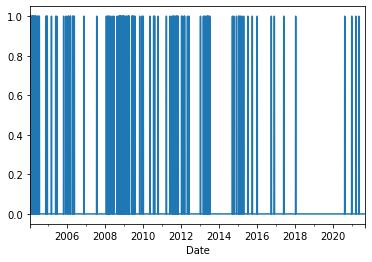

In [20]:
classification_df['ExtendedHighVolMoment_CHF/USD'].plot()

In [21]:
classification_df.head(50)

,CHF/USD Log Difference,CHF/USD Log Difference_lag_1,CHF/USD Log Difference_lag_2,CHF/USD Log Difference_lag_3,CHF/USD Log Difference_lag_4,CHF/USD Log Difference_lag_5,CHF/USD Log Difference_lag_6,CHF/USD Log Difference_lag_7,CHF/USD Log Difference_lag_8,CHF/USD Log Difference_lag_9,CHF/USD Log Difference_lag_10,CHF/USD Log Difference_lag_11,CHF/USD Log Difference_lag_12,CHF/USD Log Difference_lag_13,swiss franc_lag_1,swiss franc_lag_2,swiss franc_lag_3,swiss franc_lag_4,swiss franc_lag_5,swiss franc_lag_6,swiss franc_lag_7,swiss franc_lag_8,swiss franc_lag_9,swiss franc_lag_10,swiss franc_lag_11,swiss franc_lag_12,swiss franc_lag_13,Europe_lag_1,Europe_lag_2,Europe_lag_3,Europe_lag_4,Europe_lag_5,Europe_lag_6,Europe_lag_7,Europe_lag_8,Europe_lag_9,Europe_lag_10,Europe_lag_11,Europe_lag_12,Europe_lag_13,...,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12,energy_lag_13,1939_lag_1,1939_lag_2,1939_lag_3,1939_lag_4,1939_lag_5,1939_lag_6,1939_lag_7,1939_lag_8,1939_lag_9,1939_lag_10,1939_lag_11,1939_lag_12,1939_lag_13,CHF/USD_RealVol_lag_1,CHF/USD_RealVol_lag_2,CHF/USD_RealVol_lag_3,CHF/USD_RealVol_lag_4,CHF/USD_RealVol_lag_5,CHF/USD_RealVol_lag_6,CHF/USD_RealVol_lag_7,CHF/USD_RealVol_lag_8,CHF/USD_RealVol_lag_9,CHF/USD_RealVol_lag_10,CHF/USD_RealVol_lag_11,CHF/USD_RealVol_lag_12,CHF/USD_RealVol_lag_13,HighVolMoment_CHF/USD,ExtendedHighVolMoment_CHF/USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-21,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.006472,0.000242,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,60.0,73.0,39.0,58.0,...,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,87.0,84.0,52.0,43.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,20.0,45.0,15.0,28.0,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,0.069930,0.036245,1,0
2004-01-22,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.006472,0.0,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,60.0,73.0,39.0,...,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,87.0,84.0,52.0,6.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,20.0,45.0,15.0,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,0.069930,0,0
2004-01-23,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.0,0.0,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,66.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,60.0,73.0,...,88.0,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,87.0,84.0,33.0,6.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,20.0,45.0,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,1,0
2004-01-26,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,14.0,0.0,0.0,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,74.0,66.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,60.0,...,74.0,88.0,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,87.0,24.0,33.0,6.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,20.0,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0,0
2004-01-27,0.012024,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,0.0,14.0,0.0,0.0,24.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,79.0,70.0,74.0,66.0,80.0,67.0,61.0,64.0,69.0,66.0,68.0,75.0,67.0,...,70.0,74.0,88.0,74.0,67.0,76.0,61.0,82.0,83.0,94.0,67.0,80.0,13.0,24.0,33.0,6.0,3.0,10.0,14.0,20.0,19.0,15.0,23.0,7.0,17.0,0.036069,0.137

In [22]:
y = classification_df['ExtendedHighVolMoment_CHF/USD']
X = classification_df.drop(['CHF/USD Log Difference', 'HighVolMoment_CHF/USD', 'ExtendedHighVolMoment_CHF/USD'], axis=1)

#Train-Test Split 

In [23]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [24]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [25]:
# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

#Testing Models

##Benchmark

##Model 1: Logistic Regression


In [26]:
from sklearn.linear_model import LogisticRegression
LR1 = LogisticRegression(random_state=42, max_iter=10000).fit(X_train, y_train)

In [27]:
prob_predictions1 = LR1.predict_proba(X_test)
pred1 = prob_predictions1[:,1]

In [28]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="LR Predicted",
    mode="markers+lines", x=X_test.index, y=pred1
))

fig1.show()

In [29]:
prediction1 = LR1.predict(X_test)

In [30]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction1)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction1)}")
print(f"Precision Score: {precision_score(y_test, prediction1)}")
print(f"F1 Score: {f1_score(y_test, prediction1)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred1, squared=False)}")

Recall Score: 0.52
Accuracy Score: 0.670767004341534
Precision Score: 0.02850877192982456
F1 Score: 0.05405405405405405
RMSE of Probability Score: 0.5696422470183256


##Model 2: SGD Classifier

In [31]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
SGD2 = CalibratedClassifierCV(SGDClassifier(random_state=42, max_iter=10000)).fit(X_train, y_train)

In [32]:
prob_predictions2 = SGD2.predict_proba(X_test)
pred2 = prob_predictions2[:,1]

In [33]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="SGD2 Predicted",
    mode="markers+lines", x=X_test.index, y=pred2
))

fig1.show()

In [34]:
prediction2 = SGD2.predict(X_test)

In [35]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction2)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction2)}")
print(f"Precision Score: {precision_score(y_test, prediction2)}")
print(f"F1 Score: {f1_score(y_test, prediction2)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred2, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9819102749638206
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.17219605418653702


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



##Model 3: Passive Aggressive Classifier 

In [36]:
from sklearn.linear_model import PassiveAggressiveClassifier
PAC3 = CalibratedClassifierCV(PassiveAggressiveClassifier(max_iter=10000, random_state=42)).fit(X_train, y_train)

In [37]:
prob_predictions3 = PAC3.predict_proba(X_test)
pred3 = prob_predictions3[:,1]

In [38]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="PAC3 Predicted",
    mode="markers+lines", x=X_test.index, y=pred3
))

fig1.show()

In [39]:
prediction3 = PAC3.predict(X_test)

In [40]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction3)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction3)}")
print(f"Precision Score: {precision_score(y_test, prediction3)}")
print(f"F1 Score: {f1_score(y_test, prediction3)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred3, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9573082489146165
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.39947147918446746


##Model 4: Perceptron

In [41]:
from sklearn.linear_model import Perceptron
Per4 = CalibratedClassifierCV(Perceptron(tol=1e-3, random_state=42)).fit(X_train, y_train)

In [42]:
prob_predictions4 = Per4.predict_proba(X_test)
pred4 = prob_predictions4[:,1]

In [43]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="Per4 Predicted",
    mode="markers+lines", x=X_test.index, y=pred4
))

fig1.show()

In [44]:
prediction4 = Per4.predict(X_test)

In [45]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction4)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction4)}")
print(f"Precision Score: {precision_score(y_test, prediction4)}")
print(f"F1 Score: {f1_score(y_test, prediction4)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred4, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9819102749638206
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.17219605418653702


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



##Model 5: SVC

In [46]:
from sklearn.svm import SVC
SVC5 = SVC(probability=True).fit(X_train, y_train)

In [47]:
prob_predictions5 = SVC5.predict_proba(X_test)
pred5 = prob_predictions5[:,1]

In [48]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="SVC5 Predicted",
    mode="markers+lines", x=X_test.index, y=pred5
))

fig1.show()

In [49]:
prediction5 = SVC5.predict(X_test)

In [50]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction5)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction5)}")
print(f"Precision Score: {precision_score(y_test, prediction5)}")
print(f"F1 Score: {f1_score(y_test, prediction5)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred5, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9819102749638206
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.2361224081676398


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



##Model 6: NuSVC

In [51]:
from sklearn.svm import NuSVC
NuSVC6 = NuSVC(probability=True, nu = 0.01).fit(X_train, y_train)

In [52]:
prob_predictions6 = NuSVC6.predict_proba(X_test)
pred6 = prob_predictions6[:,1]

In [53]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="SVC5 Predicted",
    mode="markers+lines", x=X_test.index, y=pred6
))

fig1.show()

In [54]:
prediction6 = NuSVC6.predict(X_test)

In [55]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction6)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction6)}")
print(f"Precision Score: {precision_score(y_test, prediction6)}")
print(f"F1 Score: {f1_score(y_test, prediction6)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred6, squared=False)}")

Recall Score: 0.2
Accuracy Score: 0.9327062228654125
Precision Score: 0.0641025641025641
F1 Score: 0.0970873786407767
RMSE of Probability Score: 0.17508661896920644


##Model 7: Linear SVC

In [56]:
from sklearn.svm import LinearSVC
LinSVC7 = CalibratedClassifierCV(LinearSVC(random_state = 42)).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [57]:
prob_predictions7 = LinSVC7.predict_proba(X_test)
pred7 = prob_predictions7[:,1]

In [58]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="LinSVC7 Predicted",
    mode="markers+lines", x=X_test.index, y=pred7
))

fig1.show()

In [59]:
prediction7 = LinSVC7.predict(X_test)

In [60]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction7)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction7)}")
print(f"Precision Score: {precision_score(y_test, prediction7)}")
print(f"F1 Score: {f1_score(y_test, prediction7)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred7, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9623733719247467
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.3224169958921112


##Model 8: K Neighbors

In [61]:
from sklearn import neighbors
KNN8 = neighbors.KNeighborsClassifier().fit(X_train, y_train)

In [62]:
prob_predictions8 = KNN8.predict_proba(X_test)
pred8 = prob_predictions8[:,1]

In [63]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="SVR8 Predicted",
    mode="markers+lines", x=X_test.index, y=pred8
))

fig1.show()

In [64]:
prediction8 = KNN8.predict(X_test)

In [65]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction8)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction8)}")
print(f"Precision Score: {precision_score(y_test, prediction8)}")
print(f"F1 Score: {f1_score(y_test, prediction8)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred8, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9819102749638206
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.13883951526331695


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



##Model 9: Gaussian Process Classification

In [66]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process import GaussianProcessClassifier

#kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) * RBF(length_scale=0.5, length_scale_bounds=(0.0, 10.0)) + RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0))
kernel = ConstantKernel() * RBF(length_scale=0.5, length_scale_bounds=(0.0, 10.0))
GPC9 = GaussianProcessClassifier(kernel=kernel, random_state=42).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning:

divide by zero encountered in log



In [67]:
prob_predictions9 = GPC9.predict_proba(X_test)
pred9 = prob_predictions9[:,1]

In [68]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="GPC9 Predicted",
    mode="markers+lines", x=X_test.index, y=pred9
))

fig1.show()

In [69]:
prediction9 = GPC9.predict(X_test)

In [70]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction9)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction9)}")
print(f"Precision Score: {precision_score(y_test, prediction9)}")
print(f"F1 Score: {f1_score(y_test, prediction9)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred9, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9819102749638206
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.49999999518105775


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



#Model 10: Naive Bayes

In [71]:
from sklearn.naive_bayes import GaussianNB
GNB10 = GaussianNB().fit(X_train, y_train)

In [72]:
prob_predictions10 = GNB10.predict_proba(X_test)
pred10 = prob_predictions10[:,1]

In [73]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="GPC9 Predicted",
    mode="markers+lines", x=X_test.index, y=pred10
))

fig1.show()

In [74]:
prediction10 = GNB10.predict(X_test)

In [75]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction10)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction10)}")
print(f"Precision Score: {precision_score(y_test, prediction10)}")
print(f"F1 Score: {f1_score(y_test, prediction10)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred10, squared=False)}")

Recall Score: 0.6
Accuracy Score: 0.5767004341534009
Precision Score: 0.025423728813559324
F1 Score: 0.04878048780487805
RMSE of Probability Score: 0.6503297128832098


#Model 11: Decision Tree Classifier

In [76]:
from sklearn.tree import DecisionTreeClassifier
DTC11 = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [77]:
prob_predictions11 = DTC11.predict_proba(X_test)
pred11 = prob_predictions11[:,1]

In [78]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="DTC11 Predicted",
    mode="markers+lines", x=X_test.index, y=pred11
))

fig1.show()

In [79]:
prediction11 = DTC11.predict(X_test)

In [80]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction11)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction11)}")
print(f"Precision Score: {precision_score(y_test, prediction11)}")
print(f"F1 Score: {f1_score(y_test, prediction11)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred11, squared=False)}")

Recall Score: 0.44
Accuracy Score: 0.8024602026049205
Precision Score: 0.040740740740740744
F1 Score: 0.07457627118644068
RMSE of Probability Score: 0.444454494178065


##Model 12: Baggin KN Classifier

In [81]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
BAGGING12 = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5).fit(X_train, y_train)

In [82]:
prob_predictions12 = BAGGING12.predict_proba(X_test)
pred12 = prob_predictions12[:,1]

In [83]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="BAGGING12 Predicted",
    mode="markers+lines", x=X_test.index, y=pred12
))

fig1.show()

In [84]:
prediction12 = BAGGING12.predict(X_test)

In [85]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction11)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction11)}")
print(f"Precision Score: {precision_score(y_test, prediction11)}")
print(f"F1 Score: {f1_score(y_test, prediction11)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred11, squared=False)}")

Recall Score: 0.44
Accuracy Score: 0.8024602026049205
Precision Score: 0.040740740740740744
F1 Score: 0.07457627118644068
RMSE of Probability Score: 0.444454494178065


##Model 13: Random Forest Classifier

In [86]:
from sklearn.ensemble import RandomForestClassifier
RF13 = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)

In [87]:
prob_predictions13 = RF13.predict_proba(X_test)
pred13 = prob_predictions13[:,1]

In [88]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="RF13 Predicted",
    mode="markers+lines", x=X_test.index, y=pred13
))

fig1.show()

In [89]:
prediction13 = RF13.predict(X_test)

In [90]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction13)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction13)}")
print(f"Precision Score: {precision_score(y_test, prediction13)}")
print(f"F1 Score: {f1_score(y_test, prediction13)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred13, squared=False)}")

Recall Score: 0.32
Accuracy Score: 0.8552821997105644
Precision Score: 0.041884816753926704
F1 Score: 0.07407407407407408
RMSE of Probability Score: 0.31267395274245185


##Model 14: Extreme Randomized Trees

In [91]:
from sklearn.ensemble import ExtraTreesClassifier
ETC14 = ExtraTreesClassifier(random_state=42).fit(X_train, y_train)

In [92]:
prob_predictions14 = ETC14.predict_proba(X_test)
pred14 = prob_predictions14[:,1]

In [93]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="ETC14 Predicted",
    mode="markers+lines", x=X_test.index, y=pred14
))

fig1.show()

In [94]:
prediction14 = ETC14.predict(X_test)

In [95]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction14)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction14)}")
print(f"Precision Score: {precision_score(y_test, prediction14)}")
print(f"F1 Score: {f1_score(y_test, prediction14)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred14, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9717800289435601
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.2567619528554677


#Model 15: AdaBoost CLassifier

In [96]:
from sklearn.ensemble import AdaBoostClassifier
AB15 = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)

In [97]:
prob_predictions15 = AB15.predict_proba(X_test)
pred15 = prob_predictions15[:,1]

In [98]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="AB15 Predicted",
    mode="markers+lines", x=X_test.index, y=pred15
))

fig1.show()

In [99]:
prediction15 = AB15.predict(X_test)

In [100]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction15)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction15)}")
print(f"Precision Score: {precision_score(y_test, prediction15)}")
print(f"F1 Score: {f1_score(y_test, prediction15)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred15, squared=False)}")

Recall Score: 0.04
Accuracy Score: 0.9811866859623734
Precision Score: 0.3333333333333333
F1 Score: 0.07142857142857142
RMSE of Probability Score: 0.38891765785350474


##Mode 16: Gradient Tree Boosting

In [101]:
from sklearn.ensemble import GradientBoostingClassifier
GTB16 = GradientBoostingClassifier(random_state = 42).fit(X_train, y_train)

In [102]:
prob_predictions16 = GTB16.predict_proba(X_test)
pred16 = prob_predictions16[:,1]

In [103]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="GTB16 Predicted",
    mode="markers+lines", x=X_test.index, y=pred16
))

fig1.show()

In [104]:
prediction16 = GTB16.predict(X_test)

In [105]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction16)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction16)}")
print(f"Precision Score: {precision_score(y_test, prediction16)}")
print(f"F1 Score: {f1_score(y_test, prediction16)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred16, squared=False)}")

Recall Score: 0.44
Accuracy Score: 0.7988422575976846
Precision Score: 0.04
F1 Score: 0.07333333333333333
RMSE of Probability Score: 0.38713450489374335


##Model 17: Voting CLassifier

In [106]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=1, max_iter=5000)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
  scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.41 (+/- 0.28) [Logistic Regression]
Accuracy: 0.59 (+/- 0.22) [Random Forest]
Accuracy: 0.64 (+/- 0.29) [naive Bayes]
Accuracy: 0.55 (+/- 0.23) [Ensemble]


##Model 18: XGBoost

In [107]:
XGB18 = XGBClassifier(random_state=42).fit(X_train, y_train)

In [108]:
prob_predictions18 = XGB18.predict_proba(X_test)
pred18 = prob_predictions18[:,1]

In [109]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="XGB18 Predicted",
    mode="markers+lines", x=X_test.index, y=pred18
))

fig1.show()

In [110]:
prediction18 = XGB18.predict(X_test)

In [111]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction18)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction18)}")
print(f"Precision Score: {precision_score(y_test, prediction18)}")
print(f"F1 Score: {f1_score(y_test, prediction18)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred18, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9811866859623734
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.13605815224399812


#Model 19: MLP Classification

In [112]:
from sklearn.neural_network import MLPClassifier
MLP19 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42).fit(X_train, y_train)

In [113]:
prob_predictions19 = MLP19.predict_proba(X_test)
pred19 = prob_predictions19[:,1]

In [114]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="MLP19 Predicted",
    mode="markers+lines", x=X_test.index, y=pred19
))

fig1.show()

In [115]:
prediction19 = MLP19.predict(X_test)

In [116]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction19)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction19)}")
print(f"Precision Score: {precision_score(y_test, prediction19)}")
print(f"F1 Score: {f1_score(y_test, prediction19)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred19, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9819102749638206
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.17150751739343698


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



##Model 20: MLPClassification Large

In [117]:
MLP20 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10), random_state=42).fit(X_train, y_train)

In [118]:
prob_predictions20 = MLP20.predict_proba(X_test)
pred20 = prob_predictions20[:,1]

In [119]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="MLP20 Predicted",
    mode="markers+lines", x=X_test.index, y=pred20
))

fig1.show()

In [120]:
prediction20 = MLP20.predict(X_test)

In [121]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction20)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction20)}")
print(f"Precision Score: {precision_score(y_test, prediction20)}")
print(f"F1 Score: {f1_score(y_test, prediction20)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred20, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9602026049204052
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.1937850443255563
